Title: Decoding Head-Orientations using MEG

Name: Sebastian Montesinos

Collaborators: Shruti Japee, Lina Teichmann, and Chris Baker

Affiliations: Princeton University, National Institute of Mental Health (NIMH)



For this project, I focus on decoding head-orientations within the static conditions. These analyses will be used to assess the baseline capacities of a decoding model trained on static trials, which will be essential for evaluating the success of the models that we eventually use to cross-decode head-orientation in the dynamic trials. 


Methods:

Participants n=20 viewed a total of 16 stimuli of static head-orientations in a randomized, counterbalanced fashion over time. MEG was used to record neural data from 269 sensors as they viewed the stimuli. Each stimulus appeared for a total of 300 miliseconds.

Previous analyses:

The MEG data has been minimally preprocessed and epoched in a -.2 to .6 second window around stimulus onset. Next, I trained a linear discriminant classifier to decode head-orientation across all 16 conditions.

Section 1: Loading in the data, extracting some useful information, and plotting it

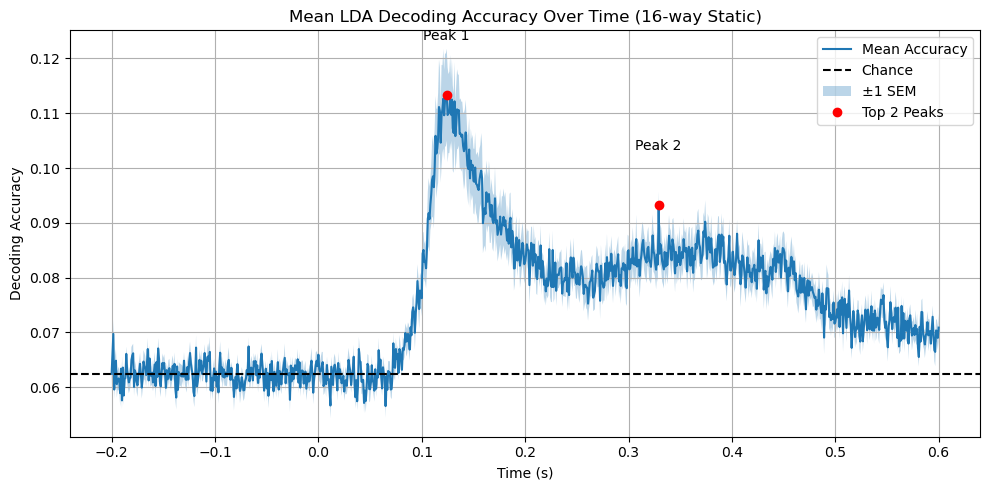

In [1]:
"First, I  load in the data, extract some useful information, and plot it"""


#Necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.signal import find_peaks
from scipy.stats import sem
from scipy.ndimage import gaussian_filter1d
import os
import csv
#### INPUT PATHS #####
# Define top directory (this is the part of the script someone will need to edit to where they clone the directory to)
top_dir = '/Users/sm6511/Desktop/Stats-Project/Stats-503-Final-Project/Final-Project' ##EDIT THIS LINE TO REPRODUCE

# This folder contains S01_DecodingAccuracyTimecourse.npy, S02_..., etc. These are the decoding timecourses per subject
base_path = os.path.join(top_dir, "data")
# Where the plots will be saved
output_dir = os.path.join(top_dir, "plots")
os.makedirs(output_dir, exist_ok=True)


#### CALCULATING MEAN ACCURACY #####
#Define a list containing the names for the subjects
subjects = [f"S{i:02}" for i in range(1, 21)]


# Load all accuracy timecourses 
all_accuracies = []
for subj in subjects:
    filepath = os.path.join(base_path, f"{subj}_DecodingAccuracyTimecourse.npy")
    if os.path.exists(filepath):
        data = np.load(filepath)
        all_accuracies.append(data)
    else:
        print(f"Missing: {filepath}")


# Stack the accuracies, compute the mean and the standard error
all_accuracies = np.vstack(all_accuracies)
mean_acc = all_accuracies.mean(axis=0)
sem_acc = sem(all_accuracies, axis=0)

# Convert samples to time in seconds (MEG samples at 1200hz, so we have to use this sampling rate to plot in miliseconds)
sampling_rate = 1200  # Hz
n_timepoints = len(mean_acc)
start_time = -0.2  # in seconds
end_time = start_time + n_timepoints / sampling_rate
time = np.linspace(start_time, end_time, n_timepoints, endpoint=False)

#For the cross-decoding analyses, I want to use two representative timepoints for training within the static
#To find these two timepoints, I look for the late and early peak in decoding

# Find all peaks with at least 10-sample distance
peaks, _ = find_peaks(mean_acc, distance=10)

# Select the highest peak overall
peak1_idx = peaks[np.argmax(mean_acc[peaks])]

# Select the highest peak after 0.2 seconds 
valid_second_peaks = [p for p in peaks if time[p] > 0.2]
if not valid_second_peaks:
    raise ValueError("No second peak found after 0.2 seconds.")
peak2_idx = valid_second_peaks[np.argmax(mean_acc[valid_second_peaks])]

# Sort peaks in time
final_peaks = np.sort([peak1_idx, peak2_idx])

# Compute peaks in miliseconds 
peak1_sample = int(final_peaks[0])
peak2_sample = int(final_peaks[1])
peak1_time_ms = round(time[peak1_sample] * 1000, 3)
peak2_time_ms = round(time[peak2_sample] * 1000, 3)

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(time, mean_acc, label='Mean Accuracy')
plt.axhline(1.0 / 16.0, color='k', linestyle='--', label='Chance')
plt.fill_between(time, mean_acc - sem_acc, mean_acc + sem_acc, alpha=0.3, label='±1 SEM') #Adds SEM labels

# Highlight the two peaks in decoding
plt.plot(time[final_peaks], mean_acc[final_peaks], 'ro', label='Top 2 Peaks')
for i, p in enumerate(final_peaks, 1):
    plt.text(time[p], mean_acc[p] + 0.01, f'Peak {i}', ha='center')
plt.xlabel('Time (s)')
plt.ylabel('Decoding Accuracy')
plt.title('Mean LDA Decoding Accuracy Over Time (16-way Static)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save plot
plot_path = os.path.join(output_dir, "Figure1aMeanDecodingAccuracy.png")
plt.savefig(plot_path, dpi=300)
plt.show()

Section 2: Looking at every subject's decoding
- It's a good idea to see how each subject looks, so I also briefly save out a plot showing the decoding lines for every subject.

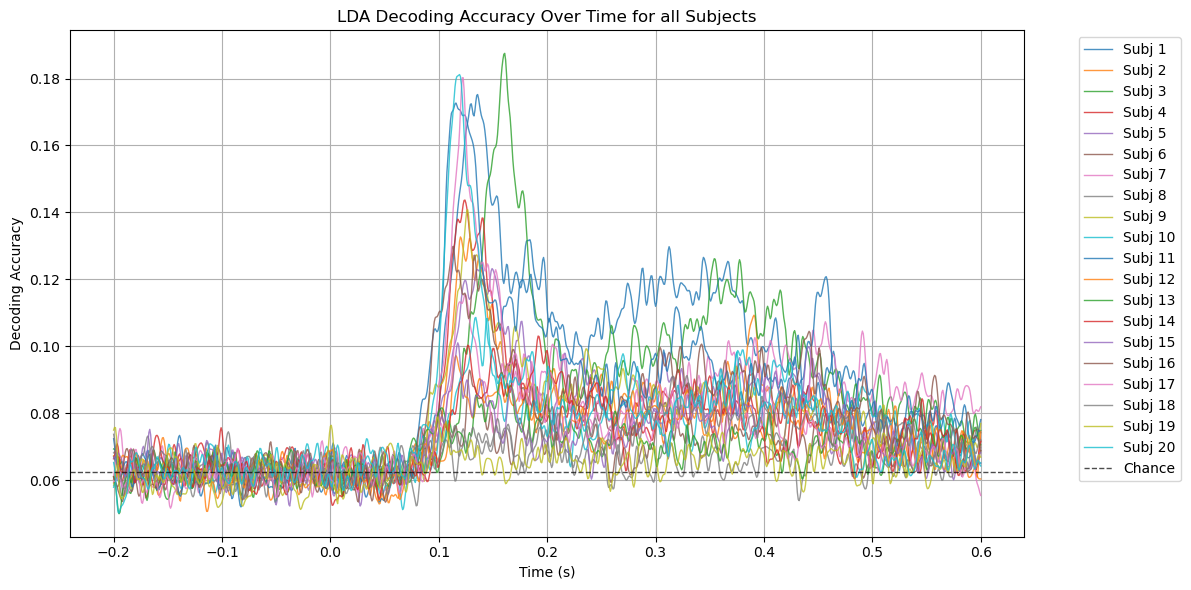

In [2]:
"""Visualizing every subject's decoding"""

# Plot
plt.figure(figsize=(12, 6))
subjID = 0
# Add transparency
for subj in all_accuracies:
    subjID +=1
    smoothed = gaussian_filter1d(subj, sigma=2) ##Added some smoothing to see the difference between subjects
    plt.plot(time, smoothed, alpha=0.8, linewidth=1, label=f'Subj {subjID}') 

# Chance line (1/16)
plt.axhline(1/16, color='k', linestyle='--', linewidth=1, alpha=0.7, label='Chance')

plt.xlabel('Time (s)')
plt.ylabel('Decoding Accuracy')
plt.title('LDA Decoding Accuracy Over Time for all Subjects')
plt.grid(True)

# Place legend outside so 20 labels don't cover the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "Figure1bAllSubjects_DecodingAccuracy.png"), dpi=300, bbox_inches='tight')
plt.show()



Section 3: Running Statistical tests

We now have an initial visualization of the decoding of head-orientations over time. However, in order to assess the model, we must apply some statistics to determine when meaningful information about head-orientation is present. In order to do this, I compute the Bayes Factor across subjects for each timepoint in the trial.

 R packages loaded successfully.
Loading subject decoding accuracies...
Loaded 20 subjects with shape (20, 961)
0.08916666666666667
First sustained decoding (>6) at 89.2 ms
Plotting group results with Bayes Factor significance..
Length mean_scores: 961
Length bf: 961


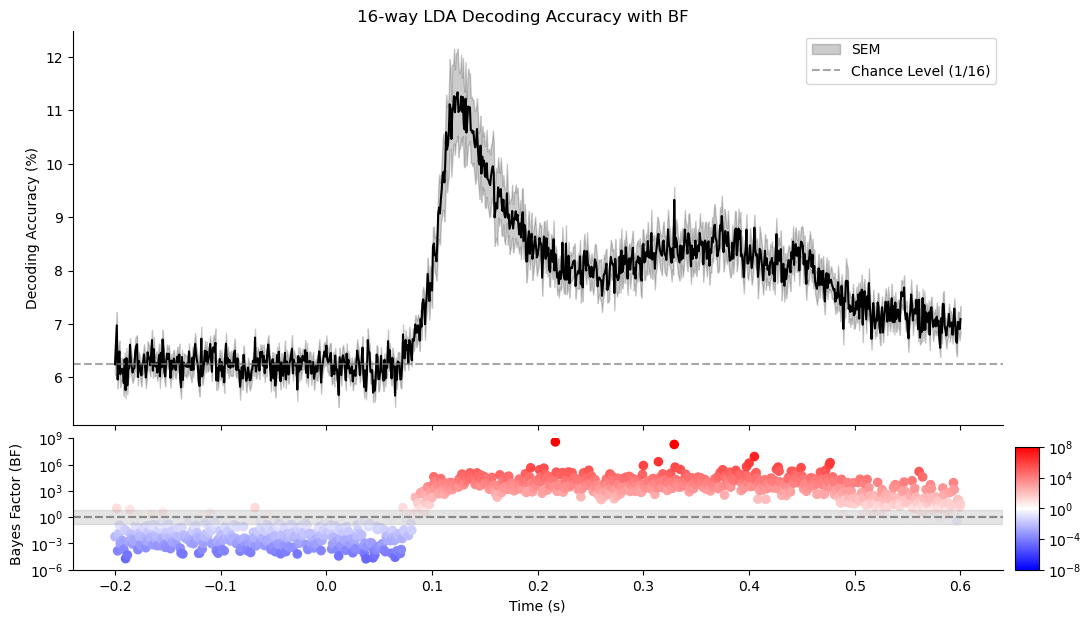

Plot saved to /Users/sm6511/Desktop/Stats-Project/Stats-503-Final-Project/Final-Project/plots/Figure1c_Group_Mean_Scores_and_BayesFactors.png
Group plot saved at: /Users/sm6511/Desktop/Stats-Project/Stats-503-Final-Project/Final-Project/plots


In [3]:

#Importing in necessary packages to apply BayesFactor
import rpy2.robjects as ro
import rpy2.robjects.conversion as conversion
from rpy2.robjects import pandas2ri, default_converter
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
from matplotlib.colors import LogNorm

#Library path to r (MUST BE ADJUSTED IF R IS IN A DIFFERENT ENVIRONMENT!)
ro.r('.libPaths("/opt/miniconda3/envs/mne2_arm/lib/R/library")')

#Conversion rules
conversion.set_conversion(default_converter + pandas2ri.converter)

#Import r
stringi = importr("stringi")
bayesfactor = importr("BayesFactor")

print(" R packages loaded successfully.") #If this step fails, check where your local R directory is set. This varies by operating system

#Parameters for BF analysis

chance = 1 / 16 #Chance in this experiment is 1/16, since there are 16 total conditions
mu = 0 #Sets the representation for exact chance level performance: I normalize the data by chance in the test
nullMin = .5 #WRITE LATER
nullMax = float('inf')
rscale = 'medium' #WRITE LATER
start_time = -0.2  # seconds
end_time = 0.6     # seconds

# Time vector for plotting
times = np.linspace(start_time, end_time, n_timepoints)

# Functions

def load_subject_scores(decoding_dir):
    """Load decoding accuracy timecourses for all subjects."""
    subject_scores = []
    subject_ids = []

    for file in sorted(os.listdir(decoding_dir)):
        if file.endswith("_DecodingAccuracyTimecourse.npy"):
            subj_id = file.split("_")[0]
            filepath = os.path.join(decoding_dir, file)
            scores = np.load(filepath)
            subject_scores.append(scores)
            subject_ids.append(subj_id)

    return np.array(subject_scores), subject_ids

def clean_axes(ax):
    "Set the right and top axes to not be visible (this is done because in the final paper this figure will be used)"
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(direction='out')

def compute_bayes_factors_group(data_2d):
    """Compute the BayesFactor for one person, given their accuracy scores. CHECK LATER"""

    normalized = data_2d - chance #Normalize the data by chance

    df = pd.DataFrame(normalized)  # wrap numpy array in pandas DataFrame

    bf = []
    #Loop over every timepoint in the trial, and compute the BF for that timepoint
    for t in range(df.shape[1]):
        with localconverter(ro.default_converter + pandas2ri.converter):
            # Convert the single column (pandas Series) to R vector
            r_vector = ro.conversion.py2rpy(df.iloc[:, t])
        #Run the bayesfactor test with the parameters previously specified (running 1 test per timepoint)
        result = bayesfactor.ttestBF(
            x=r_vector,
            mu=mu,
            rscale=rscale,
            nullInterval=ro.FloatVector([nullMin, nullMax])
        )
        bf_value = np.array(ro.r['as.vector'](result))[0]
        bf.append(bf_value) #add the result of the test to a list

    return np.array(bf) 


def find_latency(bf, times, threshold=6, n_consecutive=5):
    """Find the first timepoint where n_consecutive points exceed BF threshold."""
    above_thresh = bf > threshold
    # Slide a window of length n_consecutive length to find the first point where all are significant
    for i in range(len(above_thresh) - n_consecutive + 1):
        if np.all(above_thresh[i:i + n_consecutive]):
            latency_time = times[i]
            print(latency_time)
            print(f"First sustained decoding (>{threshold}) at {latency_time*1000:.1f} ms")
            return latency_time
    print("No sustained decoding above threshold found.")
    return None




def plot_group_results(mean_scores, bf, save_dir, times, data):
    """Plot mean decoding accuracy and Bayes Factors across timepoints."""
    """Takes in the mean decoding scores, a list of the BFs at each timepoint for those scores, a directory to save the scores, the times in the trial,"""
    """and the original non-meaned data (to compute SEM)"""
    print(f"Length mean_scores: {len(mean_scores)}")
    print(f"Length bf: {len(bf)}")

    #Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(12, 7),
        gridspec_kw={'height_ratios': [3, 1]},
        sharex=True
    )

    # Top plot: mean decoding accuracy
    sem_scores = data.std(axis=0) / np.sqrt(data.shape[0])
    ax1.plot(times, mean_scores*100, color='black')
    ax1.fill_between(times, (mean_scores - sem_scores)*100, (mean_scores + sem_scores)*100,
                    color='black', alpha=0.2, label='SEM')
    ax1.axhline(y=(1/16)*100, color='gray', linestyle='--', label='Chance Level (1/16)', alpha=.7)
    ax1.set_ylabel('Decoding Accuracy (%)')
    ax1.legend(loc='upper right')

    # Bottom plot: Bayes Factor dots
    ax2.scatter(times, bf, c=bf, cmap='bwr', norm=LogNorm(vmin=1e-8, vmax=1e8), s=35)

    ax2.set_yscale('log')
    ax2.set_ylabel('Bayes Factor (BF)')
    ax2.axhline(y=1, color='gray', linestyle='--', label='BF = 1', alpha=0.7)
    ax2.set_ylim(1e-6, 1e9)
    yticks = [1e-6, 1e-3, 1e0, 1e3, 1e6, 1e9]
    ax2.set_yticks(yticks)
    ax2.set_yticklabels([f"$10^{{{int(np.log10(t))}}}$" for t in yticks])
    ax2.set_xlabel('Time (s)')

    # Colorbar with log scale
    sc = ax2.collections[0]  # get the scatter
    pos = ax2.get_position()
    cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.height])
    cbar = fig.colorbar(sc, cax=cbar_ax, orientation='vertical')
    cbar_ticks = [1e-8, 1e-4, 1e0, 1e4, 1e8]
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([f"$10^{{{int(np.log10(t))}}}$" for t in cbar_ticks])

    bf_lower = 1/6  # BF < 1/6 is moderate evidence for the null
    bf_upper = 6    # BF > 6 is moderate evidence for the alternative
    ax2.axhspan(bf_lower, bf_upper, color='gray', alpha=0.2, label='Weak Evidence')
    ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.7)
    clean_axes(ax1)
    clean_axes(ax2)
    plt.subplots_adjust(hspace=0.05)


    fig.suptitle('16-way LDA Decoding Accuracy with BF', fontsize=12, y=.91)
    save_path = os.path.join(save_dir, 'Figure1c_Group_Mean_Scores_and_BayesFactors.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    print(f"Plot saved to {save_path}")


print("Loading subject decoding accuracies...")
data, subject_ids = load_subject_scores(base_path)
print(f"Loaded {len(subject_ids)} subjects with shape {data.shape}")

# Compute group mean and Bayes factors
mean_scores = data.mean(axis=0)
bf_group = compute_bayes_factors_group(data)

# Find latency
latency = find_latency(bf_group, times, threshold=6, n_consecutive=5)


# Plot results
print("Plotting group results with Bayes Factor significance..")
plot_group_results(mean_scores, bf_group, output_dir, times, data)
print("Group plot saved at:", output_dir)


The above plot shows decoding over time with a secondary plot showing the results of the BayesFactor test. The purpose of this test is to compare two hypotheses: the null hypothesis (N1), defined as mean decoding accuracy being at chance, and the alternative hypothesis (A1), on which mean decoding accuracy is above chance. The test is one-tailed, as we always expect only at chance or above chance decoding. The BF quantifies how likely we are to observe the data at a timepoint given N1 and A1.

We also defined a band where the evidence was 'inconclusive', from a BF of 1/6 to 6, shown in grey above. We picked this as 1/6 is typically considered the threshold for strong evidence for the null, and 6 is typically considered the threshold for strong evidence for the alternative hypothesis. Effect size is set using the nullinterval in a BF test, and previous simulations from our lab have suggested that .5 is typically the best threshold to set for effect size in MEG experiments. 

Overall, we can see that prior to the presentation of a stimulus, we find strong evidence for the null hypothesis. This result is expected, because the model should be at chance before any stimulus was on the screen. Once the stimulus is presented, the neural latency (the first of five timepoints in a row where we have more than moderate evidence for A1) is 89.2ms. This suggests an estimate for the amount of time it takes before information about face-orientation has had time to process through the visual system in a way detectable by MEG sensors. Evidence for A1 stays about the inconclusive band all the way until .6 seconds, which is .3 seconds after stimulus onset. Therefore, substantial information about head-orientation remains in someone's visual system at least 300ms after the offset of such a stimulus.